In [32]:
import pandas as pd
import numpy as np
from fastapi import FastAPI
from fastapi.middleware.cors import CORSMiddleware
from btm.ml_logic.pipe_model import pipe
from btm.ml_logic.data_predictions import load_data_predictions
from btm.ml_logic.data import load_data
from datetime import datetime
import pickle
import os
from io import BytesIO
import plotly
import nbformat

In [33]:
    #turning our prediction.csv into a DataFrame

    model = pickle.load(open('spx_final_pickle.pkl',"rb"))
    #X_dropped, y_dropped = load_data_predictions('predict_set_w_btm.csv','SPX Index ')
    X_dropped, y_dropped = load_data_predictions('total_df_w_btm.csv','SPX Index ')

    y_pred = model.predict(X_dropped)
    dict_out = {}
    for i, y in enumerate(y_pred):
        dict_out[X_dropped.index[i].to_pydatetime().strftime('%Y-%m-%d')] = \
            float(y)

    predictions_life = model.predict(X_dropped)

    predictions_life = pd.Series(predictions_life)
    predictions_life.index = y_dropped.index

    df_plot_life = pd.DataFrame()
    btm_gdp  = X_dropped['Final_GDP_Interp']

    df_plot_life = pd.concat([y_dropped, predictions_life, btm_gdp], axis=1)
    df_plot_life.info()

    df_plot_life['Market'] = df_plot_life['SPX Index ']
    df_plot_life['BTM Model'] = df_plot_life[0]
    df_plot_life['Diff'] = df_plot_life['SPX Index '] - df_plot_life[0]
    df_plot_life = df_plot_life.drop(columns=['SPX Index ', 0])
    df_plot_life['Diff Z-score'] = (df_plot_life['Diff'] - df_plot_life['Diff'].mean()) / df_plot_life['Diff'].std()

    conditions = [
    (df_plot_life['Diff Z-score'] > 2.5),
    (df_plot_life['Diff Z-score'] > 1.5),
    (df_plot_life['Diff Z-score'] < -2.5),
    (df_plot_life['Diff Z-score'] < -1.5)
    ]

    df_plot_life['BTM GDP'] = df_plot_life['Final_GDP_Interp'].fillna(method='ffill')
    df_plot_life = df_plot_life.drop(df_plot_life.columns[0], axis=1)

    values = ['Strong Sell', 'Sell', 'Strong Buy','Buy']

    # Create a new column 'Action' based on conditions and values
    df_plot_life['Action'] = np.select(conditions, values, default='Fair Value')
    print(df_plot_life)
    # Print the updated DataFrame
    print(df_plot_life)


    all_predictions = {
        'title' :'SPX Index Predictions',
        'df' : df_plot_life.to_dict()
    }


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2585 entries, 2014-05-01 to 2024-03-26
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   SPX Index         2585 non-null   float64
 1   0                 2585 non-null   float32
 2   Final_GDP_Interp  2585 non-null   float64
dtypes: float32(1), float64(2)
memory usage: 70.7 KB
             Market    BTM Model        Diff  Diff Z-score   BTM GDP  \
Dates                                                                  
2014-05-01  1883.68  1902.226196  -18.546196     -0.178646  0.110000   
2014-05-02  1881.14  1895.911255  -14.771255     -0.116630  0.152667   
2014-05-05  1884.66  1900.315674  -15.655674     -0.131160  0.280667   
2014-05-06  1867.72  1891.458252  -23.738252     -0.263942  0.323333   
2014-05-07  1878.21  1896.537354  -18.327354     -0.175050  0.366000   
...             ...          ...         ...           ...       ...   
2024-03-20  

In [34]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Creating a figure with secondary_y axis (two y-axes)
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Function to generate hover text including the 'Action'
def create_hover_text(df):
    return [f"{date.strftime('%Y-%m-%d')}<br>Market: {market}<br>BTM Model: {model}<br>Action: {action}"
            for date, market, model, action in zip(df.index, df['Market'], df['BTM Model'], df['Action'])]

# Custom hover text for all data points
hover_text = create_hover_text(df_plot_life)

# Adding Market and BTM Model as line plots with custom hover info
fig.add_trace(
    go.Scatter(x=df_plot_life.index, y=df_plot_life['Market'], name='Market', mode='lines',
               line=dict(color='blue'), text=hover_text, hoverinfo='text'),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=df_plot_life.index, y=df_plot_life['BTM Model'], name='BTM Model', mode='lines',
               line=dict(color='green'), text=hover_text, hoverinfo='text'),
    secondary_y=False,
)

# Modifying the 'Diff Z-score' bar chart to include 'Action' in hover
fig.add_trace(
    go.Bar(x=df_plot_life.index, y=df_plot_life['Diff Z-score'], name='Signal Strength',
           marker_color='pink', opacity=0.5, width=0.5,
           marker_line_color='pink', marker_line_width=1,
           text=hover_text, hoverinfo='text'),  # Include custom hover info
    secondary_y=True,
)

# Adding titles and labels
fig.update_layout(
    title_text="S&P500 vs BTM Model with Signal Strength",
    plot_bgcolor='white', paper_bgcolor='white',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Value'),
    yaxis2=dict(title='Signal Strength')
)

# Show plot
fig.show()


In [55]:

# Define the mapping of original feature names to new, interpretable names
feature_name_map = {
    'value_CCLACBW027SBOG': 'CreditCards_Loans',
    'value_WTISPLC': 'WTI_Price',
    'value_EXPINF1YR': 'Infl_Exp_1Y_Surv',
    'value_STLPPM': 'Gold_Price',
    'value_M2REAL': 'Real_M2',
    'value_UNRATE': 'Unemp_Rate',
    'value_PPIACO': 'All_ProducerPrices',
    'value_PCUOMFGOMFG': 'Mfg_ProducerPrices',
    'value_PCUATRANSATRANS': 'Transport_ProducerPrices',
    'value_PCUATRADEATRADE': 'Trade_ProducerPrices',
    'value_PCUAWHLTRAWHLTR': 'Wholesale_ProducerPrices',
    'value_CSUSHPINSA': 'Home_Prices',
    'value_SPCS20RSA': 'S&P_20_City_Home_Prices',
    'value_WALCL': 'FedReserve_Assets',
    'value_REAINTRATREARAT10Y': 'Real_Rates_10Y',
    'value_SAHMREALTIME': 'Sahm_Rule',
    'value_POPTHM': 'Population',
    'value_CES0500000003': 'Avg_Hourly_Earn',
    'value_NFCI': 'ChiFed_NFCI',
    'value_WEI': 'Weekly_Econ_Ind',
    'value_ICSA': 'Initial_Jobless_Claims',
    'value_ADPWNUSNERSA': 'ADP_Employment',
    'value_FEDFUNDS': 'Fed_Funds_Rate',
    'value_CORESTICKM159SFRBATL': 'Core_Infl',
    'value_CPIAUCSL': 'CPI',
    'value_PAYEMS': 'Nonfarm_Employ',
    'value_MORTGAGE30US': 'Mortgage_30Y',
    'USGGBE02 Index': 'US_2Y_Infl_Market_Hedge_Price',
    'USOSFR10 Curncy': 'USD_10Y_IR',
    'CL1 Comdty': 'Oil_Futures',
    'GSUSFCI Index': 'GS_FinCond_Index',
    'CESIUSD Index': 'Citi_EconSupr_Index',
    'Monthly Nominal GDP Index': 'Nom_GDP_Mo',
    'Monthly Real GDP Index': 'Real_GDP_Mo',
    'Structures': 'Construction',
    'USOSFR2 Curncy': 'USD_2Y_Interest_Rate',
}


In [56]:
import shap
# Prepare the last observation for SHAP analysis
X_waterfall = X_dropped.loc['2024-01-19':]

# Compute SHAP values for the last observation
explainer = shap.Explainer(model.predict, X_waterfall)
shap_values = explainer(X_waterfall)

# Apply the mapping to the SHAP values feature names
# This step assumes shap_values.data is a DataFrame; if not, adjust as necessary
if hasattr(shap_values, 'feature_names'):
    shap_values.feature_names = [feature_name_map.get(name, name) for name in shap_values.feature_names]

# # # # For visualization like waterfall, which typically uses the base_values and feature values
# # # # The feature names can be directly mapped in the visualization step if not inherent to the SHAP values object
# shap.summary_plot(shap_values, max_display=10, feature_names=[feature_name_map.get(name, name) for name in X_dropped.columns])


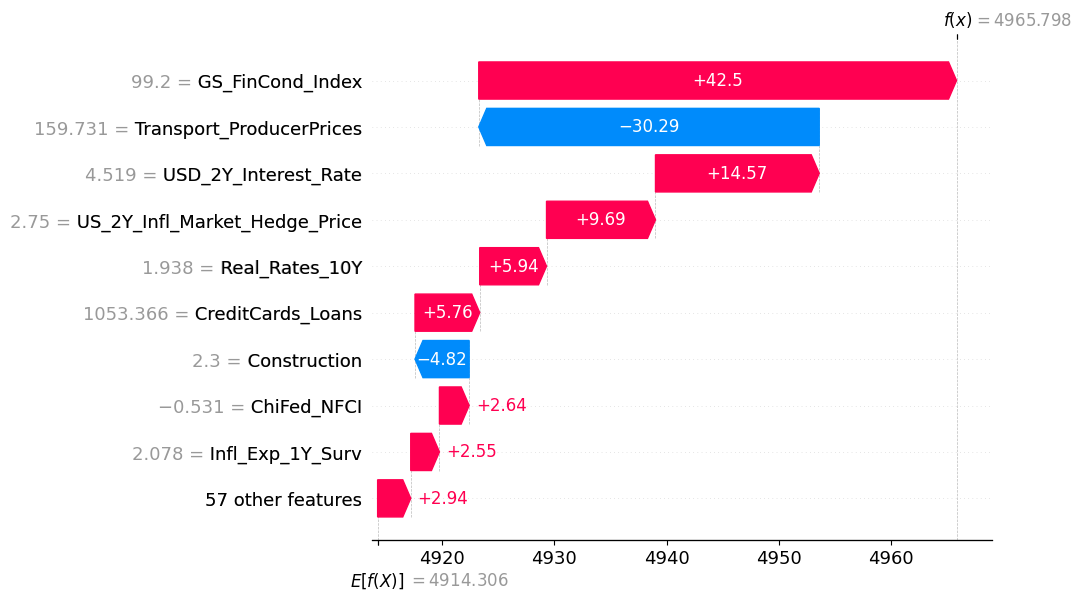

In [57]:
from shap import Explanation
from shap.plots import waterfall

# Assuming 'shap_values' is already computed for 'X_waterfall'
# Let's assume 'shap_values_one' represents the SHAP values for the last observation
shap_values_one = shap_values[-1]

# Map feature names from 'X_dropped.columns' to the names in 'feature_name_map'
mapped_feature_names = [feature_name_map.get(name, name) for name in X_dropped.columns]

# Create an Explanation object with mapped feature names
exp = Explanation(values=shap_values_one.values,
                  base_values=shap_values_one.base_values,
                  data=shap_values_one.data,
                  feature_names=mapped_feature_names)

# Use the waterfall plot for the Explanation object
waterfall(exp)


In [19]:
# Feature Selection
import shap
# Compute SHAP values
# # Initialize the explainer on the entire pipeline
explainer = shap.Explainer(model.predict, X_dropped)
# Compute SHAP values
shap_values = explainer(X_dropped)
# # Visualize the feature importance
# shap.plots.bar(shap_values)
# Plot SHAP values to understand feature importance
# # shap.summary_plot(shap_values, X_test, plot_type="bar")
# shap.plots.beeswarm(shap_values)
#change

PermutationExplainer explainer:   1%|          | 13/2585 [04:30<16:07:31, 22.57s/it]


KeyboardInterrupt: 

In [11]:

shap.plots.waterfall(shap_values[0])
#change

NameError: name 'shap_values' is not defined